In [ ]:
!pip install transformers --quiet

     |████████████████████████████████| 5.5 MB 32.0 MB/s 
     |████████████████████████████████| 7.6 MB 40.1 MB/s 
     |████████████████████████████████| 182 kB 73.6 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sns
import itertools 
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import os

rc={'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 10.0, 
    'axes.titlesize': 32, 'xtick.labelsize': 20, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)
mpl.rcParams['axes.linewidth'] = .5 #set the value globally
import seaborn as sns; sns.set()
sns.set_style("whitegrid")
mpl.rcParams['axes.linewidth'] = 0.0 #set the value globally

import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [ ]:
#@title Utilities

def get_adjmat(mat, input_tokens):
    n_layers, length, _ = mat.shape
    adj_mat = np.zeros(((n_layers+1)*length, (n_layers+1)*length))
    labels_to_index = {}
    for k in np.arange(length):
        labels_to_index[str(k)+"_"+input_tokens[k]] = k

    for i in np.arange(1,n_layers+1):
        for k_f in np.arange(length):
            index_from = (i)*length+k_f
            label = "L"+str(i)+"_"+str(k_f)
            labels_to_index[label] = index_from
            for k_t in np.arange(length):
                index_to = (i-1)*length+k_t
                adj_mat[index_from][index_to] = mat[i-1][k_f][k_t]
                
    return adj_mat, labels_to_index 


def draw_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        
        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')
    
    return G

def get_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        
        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')
    
    return G

def compute_flows(G, labels_to_index, input_nodes, length):
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in labels_to_index:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()
            
    return flow_values

def compute_node_flow(G, labels_to_index, input_nodes, output_nodes,length):
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in output_nodes:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()
            
    return flow_values

def compute_joint_attention(att_mat, add_residual=True):
    if add_residual:
        residual_att = np.eye(att_mat.shape[1])[None,...]
        aug_att_mat = att_mat + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(axis=-1)[...,None]
    else:
       aug_att_mat =  att_mat
    
    joint_attentions = np.zeros(aug_att_mat.shape)

    layers = joint_attentions.shape[0]
    joint_attentions[0] = aug_att_mat[0]
    for i in np.arange(1,layers):
        joint_attentions[i] = aug_att_mat[i].dot(joint_attentions[i-1])
        
    return joint_attentions

def plot_attention_heatmap(att, s_position, t_positions, sentence):

  cls_att = np.flip(att[:,s_position, t_positions], axis=0)
  xticklb = input_tokens= list(itertools.compress(['<cls>']+sentence.split(), [i in t_positions for i in np.arange(len(sentence)+1)]))
  yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
  ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
  return ax


def convert_adjmat_tomats(adjmat, n_layers, l):
   mats = np.zeros((n_layers,l,l))
   
   for i in np.arange(n_layers):
       mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]
       
   return mats

### load pretrained model

#### bert

In [ ]:
pretrained_weights = 'bert-base-uncased'
model = AutoModelForMaskedLM.from_pretrained(pretrained_weights,
                                             output_hidden_states=True,
                                             output_attentions=True)
model.zero_grad() # 모델의 모든 가중치의 gradient를 0d으로 -> 주로 매 학습 루프에서 필요함
tokenizer = AutoTokenizer.from_pretrained(pretrained_weights, use_fast=True)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

### test (bert)

In [ ]:

sentences = {}
src = {}
targets = {}
sentences[1] = "She asked the doctor about "+tokenizer.mask_token+" backache"
src[1] = 6
targets[1] = (1,4) 
sentences[0] = "He talked to her about his book"
src[0] = 6
targets[0] = (1,4) 
sentences[2] = "The author talked to Sara about "+tokenizer.mask_token+" book"
src[2] = 7
targets[2] = (2,5) 

sentences[3] = "John tried to convince Mary of his love and brought flowers for "+tokenizer.mask_token
src[3] = 13
targets[3] = (1,5) 

sentences[4] = "Mary convinced John of "+tokenizer.mask_token+" love"
src[4] = 5
targets[4] = (1,3) 

ex_id = 2
sentence = sentences[ex_id]
tokens = ['[cls]']+tokenizer.tokenize(sentence)+['[sep]']
print("number of tokens is ",len(tokens),"\nthe tokens are", tokens)
tf_input_ids = tokenizer.encode(sentence)
print(tokenizer.decode(tf_input_ids))
input_ids = torch.tensor([tf_input_ids])
model_output = model(input_ids)
all_hidden_states, all_attentions  = model_output['hidden_states'], model_output['attentions']

_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

number of tokens is  10 
the tokens are ['[cls]', 'the', 'author', 'talked', 'to', 'sara', 'about', '[MASK]', 'book', '[sep]']
[CLS] the author talked to sara about [MASK] book [SEP]
(12, 12, 10, 10)


In [ ]:
model_output.keys()

odict_keys(['logits', 'hidden_states', 'attentions'])

In [ ]:
model_output['attentions'][0]

torch.Size([1, 12, 10, 10])

In [ ]:
output = model(input_ids)[0]
predicted_target = torch.nn.Softmax()(output[0,src[ex_id]])

print(np.argmax(output.detach().numpy()[0], axis=-1))
print(tokenizer.decode(np.argmax(output.detach().numpy()[0], axis=-1)))
print(tf_input_ids[src[ex_id]], tokenizer.decode([tf_input_ids[src[ex_id]]]))
print(tf_input_ids[targets[ex_id][0]], tokenizer.decode([tf_input_ids[targets[ex_id][0]]]), predicted_target[tf_input_ids[targets[ex_id][0]]])
print(tf_input_ids[targets[ex_id][1]], tokenizer.decode([tf_input_ids[targets[ex_id][1]]]), predicted_target[tf_input_ids[targets[ex_id][1]]])

his_id = tokenizer.encode('his')[1]
her_id = tokenizer.encode('her')[1]

print(his_id, her_id)
print("his prob:", predicted_target[his_id], "her prob:", predicted_target[her_id], "her?", predicted_target[her_id] > predicted_target[his_id])

[1012 1996 3166 5720 2000 7354 2055 1996 1012 1012]
. the author talked to sara about the..
103 [MASK]
3166 author tensor(5.9873e-06, grad_fn=<SelectBackward0>)
7354 sara tensor(5.9435e-07, grad_fn=<SelectBackward0>)
2010 2014
his prob: tensor(0.0700, grad_fn=<SelectBackward0>) her prob: tensor(0.1019, grad_fn=<SelectBackward0>) her? tensor(True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


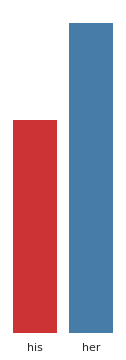

In [ ]:
fig = plt.figure(1,figsize=(2,6))
ax = sns.barplot(['his', 'her'], [ float(predicted_target[his_id].detach().numpy()),  float(predicted_target[her_id].detach().numpy())], linewidth=0, palette='Set1')
sns.despine(fig=fig, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
ax.set_yticks([])
plt.savefig('rat_bert_bar_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

In [ ]:
attentions_mat.shape

(12, 12, 10, 10)

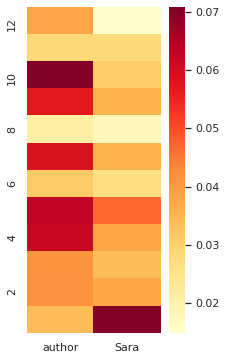

In [ ]:
plt.figure(1,figsize=(3,6))
plot_attention_heatmap(attentions_mat.sum(axis=1)/attentions_mat.shape[1], src[ex_id], t_positions=targets[ex_id], sentence=sentence)


In [ ]:
#@title Get raw attention mat + residual connections

res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]
 
res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)



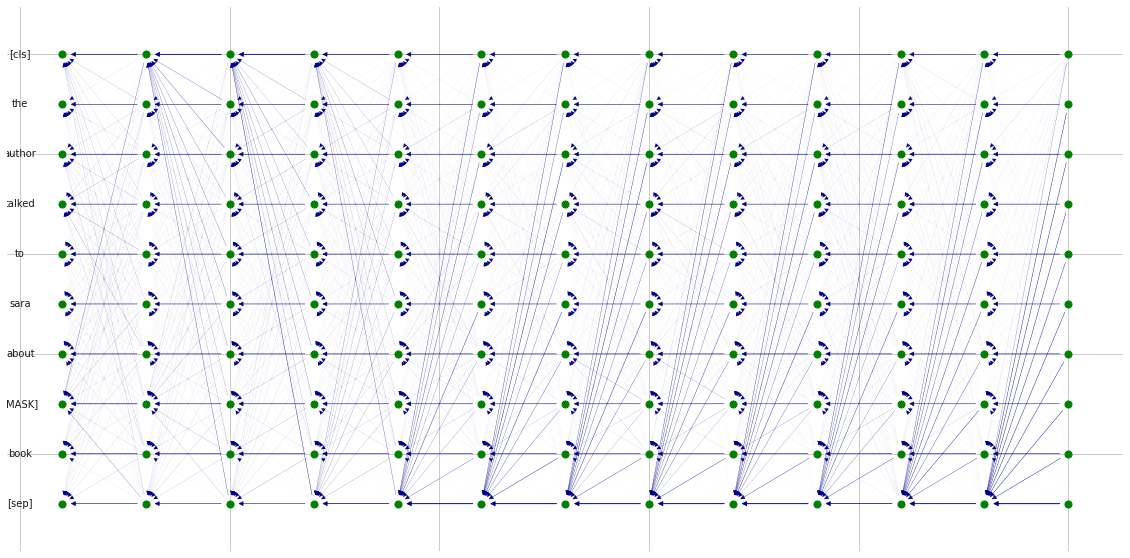

In [ ]:
#@title plot the attention graph
plt.figure(figsize=(20,10))
res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])

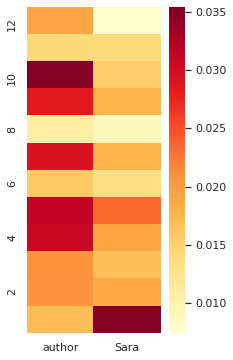

In [ ]:
#@title Plot contrastive heatmap

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(res_att_mat, src[ex_id], t_positions=targets[ex_id], sentence=sentence)


In [ ]:
#@title Compute attention rollout

joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens)


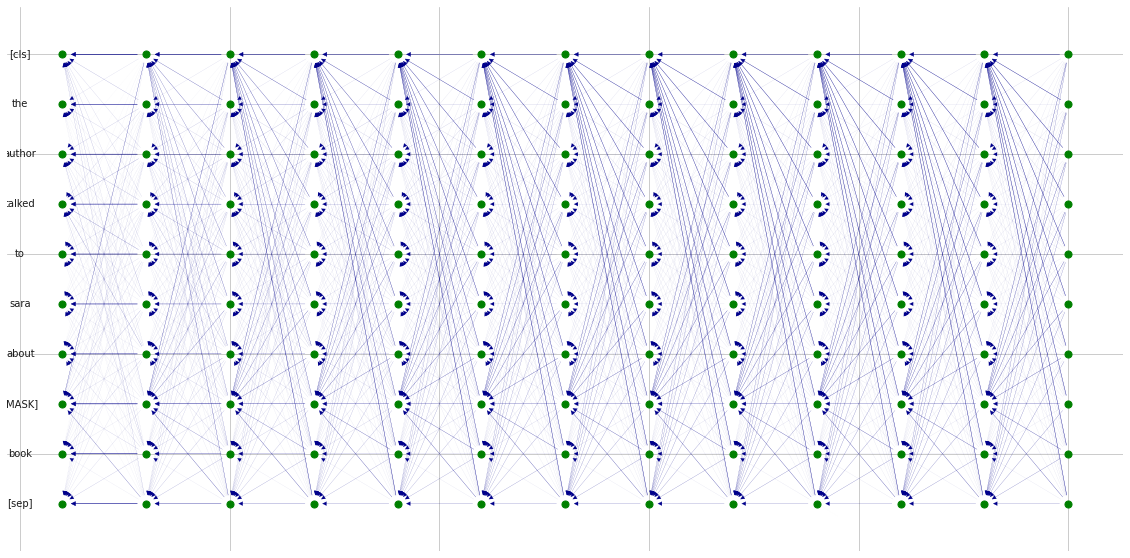

In [ ]:
#@title Draw attention rollout graph
plt.figure(figsize=(20,10))
G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])

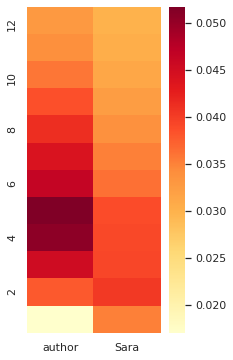

In [ ]:
#@title Plot contrastive heatmap

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(joint_attentions, src[ex_id], t_positions=targets[ex_id], sentence=sentence)


In [ ]:
#@title Compute attention flow (this will take quite some time to compute).

output_nodes = []
input_nodes = []
for key in res_labels_to_index:
    if 'L24' in key:
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])


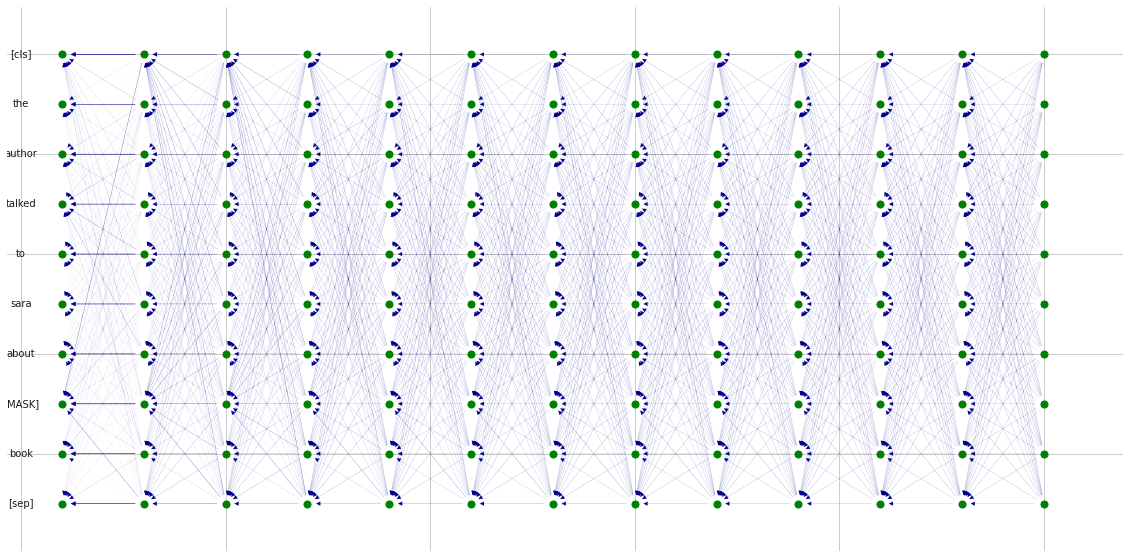

In [ ]:
#@title Draw attention flow graph

plt.figure(figsize=(20,10))
flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])

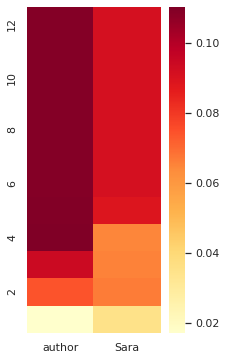

In [ ]:
#@title Plot contrastive heatmap
flow_att_mat = convert_adjmat_tomats(flow_values, n_layers=attentions_mat.shape[0], l=attentions_mat.shape[-1])

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(flow_att_mat, src[ex_id], t_positions=targets[ex_id], sentence=sentence)

### vit

In [ ]:
!pip install timm --quiet

     |████████████████████████████████| 548 kB 4.8 MB/s 
     |████████████████████████████████| 182 kB 67.8 MB/s 


In [ ]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model.zero_grad()

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
!pip install torchviz --quiet

In [ ]:
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate=none)
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fal

In [ ]:
# transformer 부분이 sequential block이라 확인하는 법이 조금 다름
model.blocks._modules['11']

Block(
  (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=768, out_features=2304, bias=True)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): Identity()
  (drop_path1): Identity()
  (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate=none)
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (ls2): Identity()
  (drop_path2): Identity()
)

In [ ]:
model.blocks._modules['11'].attn

Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

In [ ]:
# 중간결과를 뽑기위한 코드
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.patch_embed.register_forward_hook(get_activation('patch_embed'))
for i in range(0,12):
  model.blocks._modules[str(i)].drop_path2.register_forward_hook(get_activation('encoder_block_'+str(i)))
model.norm.register_forward_hook(get_activation('norm'))
model.fc_norm.register_forward_hook(get_activation('fc_norm'))
model.head.register_forward_hook(get_activation('head'))

### test(vit)

In [ ]:
from PIL import Image
import requests
from torchvision.io import read_image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

url = "https://www.akc.org/wp-content/uploads/2015/06/Golden-Retriever-laying-down-playing-with-a-cat.jpeg"
image = Image.open(requests.get(url, stream=True).raw)

# PIL에서 텐서로 형 바꾸기
from torchvision.transforms import ToTensor
image = ToTensor()(image).unsqueeze(0)

# 이미지 크기를 224,224로 바꾸기
import torchvision.transforms as T
resize = T.Resize((224,224))
image = resize(image)

In [ ]:
model_output = model(image) 

In [ ]:
# 모델구조 plot해서 저장
import torchviz
model_architecture = torchviz.make_dot(model_output, params=dict(model.named_parameters()))
model_architecture.render(filename='vit',view=True)


'vit.pdf'

In [ ]:
with open('imagenet1000_clsidx_to_labels.txt','r') as f:
  idx2labels = f.readlines()

In [ ]:
import numpy as np
values, indices = model_output.topk(10)
indices = indices.cpu().detach().numpy()
indices = np.squeeze(indices).tolist()
[idx2labels[index] for index in indices]

[" 207: 'golden retriever',\n",
 " 219: 'cocker spaniel, English cocker spaniel, cocker',\n",
 " 852: 'tennis ball',\n",
 " 195: 'Boston bull, Boston terrier',\n",
 " 232: 'Border collie',\n",
 " 260: 'chow, chow chow',\n",
 " 264: 'Cardigan, Cardigan Welsh corgi',\n",
 " 604: 'hourglass',\n",
 " 213: 'Irish setter, red setter',\n",
 " 263: 'Pembroke, Pembroke Welsh corgi',\n"]

In [ ]:
for key in activation.keys():
  print(key,":",activation[key].shape)

patch_embed : torch.Size([1, 196, 768])
encoder_block_0 : torch.Size([1, 197, 768])
encoder_block_1 : torch.Size([1, 197, 768])
encoder_block_2 : torch.Size([1, 197, 768])
encoder_block_3 : torch.Size([1, 197, 768])
encoder_block_4 : torch.Size([1, 197, 768])
encoder_block_5 : torch.Size([1, 197, 768])
encoder_block_6 : torch.Size([1, 197, 768])
encoder_block_7 : torch.Size([1, 197, 768])
encoder_block_8 : torch.Size([1, 197, 768])
encoder_block_9 : torch.Size([1, 197, 768])
encoder_block_10 : torch.Size([1, 197, 768])
encoder_block_11 : torch.Size([1, 197, 768])
norm : torch.Size([1, 197, 768])
fc_norm : torch.Size([1, 768])
head : torch.Size([1, 1000])


In [ ]:
#@title attention roll out
# https://jacobgil.github.io/deeplearning/vision-transformer-explainability

